In [15]:
import torch
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch.nn.functional as F
from collections import defaultdict
import copy
import sys
from scipy import ndimage
cmap=plt.cm.Spectral_r
from mpl_toolkits import mplot3d
from pathlib import Path
from utils import get_data
from main import test
from models import FullyConnected
import string

sys.path.append('.')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':12,
    "lines.linewidth":3.0,
    "savefig.dpi":500
})
cmap = plt.get_cmap('Spectral_r')

savedir= './figs/'.format(**params)
if not os.path.exists(savedir):
    os.mkdir(savedir)

# Helpers

In [6]:
def find(array, value):
    idx= np.argwhere(np.array(array)==value)[0,0]
    return idx

def h2p(width, input_size, depth):
    return input_size*width + (depth-1) * width**2 + width
h2p = np.vectorize(h2p)

def select_runs(runs, params, constraints):
    selected_runs = []
    for irun, run in enumerate(runs):
        keep = True
        for k,v in constraints.items():
            if getattr(run['args'],k) != v:
                keep = False
                break
        if keep:
            selected_runs.append(run)
    selected_params = copy.deepcopy(params)
    for con in constraints:
        selected_params[con]=[constraints[con]]
    return selected_runs, selected_params

def group_runs(runs, finished_only=True):
    runs_grouped = defaultdict(list)
    for run in runs:
        seedless_args = copy.deepcopy(run['args'])
        del(seedless_args.seed)
        del(seedless_args.name)
        if str(seedless_args) not in runs_grouped.keys(): 
            runs_grouped[str(seedless_args)].append(run) # need at least one run
        else:
            if run['finished'] or not finished_only:
                runs_grouped[str(seedless_args)].append(run)
    runs_grouped = list(runs_grouped.values())
    return runs_grouped

def flatten(weights):
    return torch.cat([w.view(-1) for w in weights.values()])

def interpolate(w1, w2, alpha):
    w3 = copy.deepcopy(w1)
    for (k1,p1), (k2,p2) in zip(w1.items(), w2.items()):
        w3[k1] = alpha * p1 + (1-alpha) * p2
    return w3

def last_non_nan(array):
    return (~np.isnan(array)).cumsum(1).argmax(1)

def calc_ens_acc(group, test_loader):
    args = group[0]['args']
    x,y = list(test_loader)[0]
    for run in group:
        model = FullyConnected(input_size = input_channels * input_size**2,
                       output_size=output_size, hidden_size=args.hidden_size, n_layers=args.n_layers,
                       training_method=args.training_method, activation=args.activation, 
                       feedback_init=args.feedback_init, weight_init = args.weight_init)
        model.load_state_dict(run['weights'])
        outs.append(model(x))
    y_pred = torch.stack(outs).mean(dim=0).max(1)[1]
    ens_acc = y_pred.eq(y).sum().float()/len(y)*100
    return ens_acc

def calc_weight_alignments(group):
    if not isinstance(group,list):
        group = [group]
    args = group[0]['args']
    alignments = {l:[] for l in range(1,args.n_layers)}
    for run in group:  
        b = run['feedback_matrix']
        if type(run['weights'])==list: weights = run['weights'][-1]
        else: weights = run['weights']
        for l in range(1,args.n_layers):
            w = weights['layers.{}.weight'.format(l)].view(-1)
            if l == args.n_layers-1:
                v = b[-1].view(-1)
            else:
                v = (b[l].t()@b[l-1]).view(-1)
            a = w @ v / w.norm() / v.norm()
            if np.isnan(a):
                print('nan ', end=' ')
                continue
            alignments[l].append(a)
    return alignments

def calc_time_angles(group):

    angles = []
    for t in range(len(group[0]['weights'])):
        angles_tmp = []
        weights = []
        for run in group:
            try: weights.append(run['weights'][t])
            except: continue
        for i1, w1 in enumerate(weights):
            for i2, w2 in enumerate(weights):
                if i1<=i2: continue
                angle = flatten(w1)@flatten(w2).t()/flatten(w1).norm()/flatten(w2).norm()
                if not np.isnan(angle):
                    angles_tmp.append(angle.item())
        angles.append(angles_tmp)
    return angles

def calc_final_angles(group):

    weights = []
    angles = defaultdict(list)
    for run in group:
        if type(run['weights'])==list: 
            weights.append(run['weights'][-1])
        else: 
            weights.append(run['weights'])
    for i1, w1 in enumerate(weights):
        for i2, w2 in enumerate(weights):
            if i1<=i2: continue
            angle = flatten(w1)@flatten(w2).t()/flatten(w1).norm()/flatten(w2).norm()
            if not np.isnan(angle):
                angles['total'].append(angle.item())
            for l, (p1, p2) in enumerate(zip(w1.values(), w2.values())):
                angle = p1.view(-1) @ p2.view(-1).t()/p1.norm()/p2.norm().item()
                if not np.isnan(angle):
                    angles[l].append(angle.item())
    return angles

# Load runs

In [30]:
paths = sorted(glob.glob('r.*'), key=os.path.getmtime)
last = paths[-1]
path+='/'
print(path)

def load_runs(path):

    runs = []
    params = torch.load(path+'params.pkl')
    for k, v in params.items():
        print(k,v)
    files = glob.glob(path + '*.pyT')
    for ifile, file in enumerate(files):
        if ifile%(len(files)//4)==0:
            print(ifile, 'out of', len(files))
        try:
            run = torch.load(file)
        except:
            continue
        torch.save(run, file)
        runs.append(run)

    return runs, params

runs, params = get_runs(path)

r.1601980811/
seed range(0, 10)
label_noise [0.0]
hidden_size [100]
n_layers [3]
activation ['linear', 'tanh', 'relu']
dataset ['RANDOM']
epochs [10000]
log_every [100]
training_method ['DFA']
feedback_init ['UNIFORM']
weight_init ['UNIFORM']
learning_rate [0.0001]
momentum [0.0]
batch_size [32]
test_batch_size [1000]
model ['fc']
no_gpu [True]
dataset_path ['~/data']
datasize [1000]
num_classes [2]
input_dim [16]
optimizer ['SGD']
task ['REGRESSION']
alpha [0.2, 0.4, 0.6, 0.8, 1.0]
beta [0.2, 0.4, 0.6, 0.8, 1.0]
0 out of 113
28 out of 113
56 out of 113
84 out of 113
112 out of 113


# Dynamics at fixed width

In [ ]:
path = 'r.1601840497/' # path to folder generated by submit_width.py
runs, params = load_runs(path)

In [ ]:
colors = {'MNIST relu':'C0', 'MNIST tanh':'C1', 'CIFAR10 relu':'C2', 'CIFAR10 tanh':'C3'}

def calc_time_angles(group):

    angles = []
    for t in range(len(group[0]['weights'])):
        angles_tmp = []
        weights = []
        for run in group:
            try: weights.append(run['weights'][t])
            except: continue
        for i1, w1 in enumerate(weights):
            for i2, w2 in enumerate(weights):
                if i1<=i2: continue
                angle = flatten(w1)@flatten(w2).t()/flatten(w1).norm()/flatten(w2).norm()
                if not np.isnan(angle):
                    angles_tmp.append(angle.item())
        angles.append(angles_tmp)
    return angles

grouped_runs = group_runs(runs, finished_only=True)

angle_dict = {}
train_acc_dict = {}
wa_dict = {}
ga_dict = {}

for igroup, group in enumerate(grouped_runs):
    print(igroup, 'out of', len(grouped_runs))
    args = group[0]['args']
    key  =(args.dataset, args.activation, args.training_method)
    ls   = '-' if args.training_method == 'DFA' else ':'

    train_acc_dict[key] = np.mean(np.array([run['train_accs'] for run in group]), axis=0)
    if args.training_method == 'DFA':
        wa_dict[key] = np.mean(np.array([run['weight_alignments']['total'] for run in group]), axis=0)
        ga_dict[key] = np.mean(np.array([run['grad_alignments']  ['total'] for run in group]), axis=0)
    
    angles = calc_final_angles(group)['total']
    angles_history = calc_time_angles(group)
    epochs1 = np.array(range(len(angles_history)))*args.save_every+1
    angle_dict[key] = [np.nanmean(angles) for angles in angles_history]
    epochs2 = np.linspace(0, max(epochs1), len(train_acc))+1

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, axarr = plt.subplots(1,4, figsize=(12,3))

for key in angle_dict.keys():
    label = '{} {}'.format(key[0], key[1])
    color= colors[label]
    ls = '-' if key[2] == 'DFA' else ':'
    axarr[0].plot(epochs2, 100-train_acc_dict[key], color=color, ls=ls)
    if key[2]=='DFA':
        axarr[1].plot(epochs2, wa_dict[key], color=color, ls=ls)
        axarr[2].plot(epochs2, ga_dict[key], color=color, ls=ls)    
        axarr[3].plot(epochs1, angle_dict[key], label=(label if key[2]=='DFA' else ''), color=color, ls=ls)
    else: 
        axarr[3].plot(epochs1, angle_dict[key], color=color, ls=ls)

axarr[3].plot([],[],color='k', lw=1, label='DFA')
axarr[3].plot([],[],color='k', ls=':', lw=1, label='BP')
axarr[3].legend(bbox_to_anchor=(1.1,.9))

for i, ax in enumerate(axarr):
    ax.set_xscale('log')
    ax.set_xlabel('Epochs')
    ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
axarr[3].set_yscale('log')

axarr[0].set_ylabel('Train error')
axarr[1].set_ylabel('Weight alignment')
axarr[2].set_ylabel('Gradient alignment')
axarr[3].set_ylabel('Cosine similarity')

plt.tight_layout()
plt.savefig(savedir+'Dynamics_angle.pdf', bbox_inches='tight')
plt.show()

# Varying label noise

In [ ]:
path = 'r.1601976778/' # path to folder generated by submit_noise.py
runs, params = load_runs(path)

In [ ]:
label_key = 'label_noise'
legend_key = 'p'
x = params[label_key]

for dataset in ['MNIST','CIFAR10']:
    for activation in ['relu', 'tanh', 'linear']:

        constraints = {'dataset' : dataset,
                      'activation' : activation,}
        
        selected_runs, _ = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=True)

        fig, axarr = plt.subplots(1,2, figsize=(7,3))
        axins = inset_axes(axarr[1], width='40%', height='40%', loc=2)
        
        n_steps = len(runs[0]['test_loss'])
        for group in grouped_runs:
            args = group[0]['args']
            i = find(x,getattr(args, label_key))
            train_acc = np.mean([run['train_accs']  for run in group], axis=0)
            test_acc = np.mean([run['test_accs']  for run in group], axis=0)
            wa = np.mean([run['weight_alignments']['total'] for run in group], axis=0)
            ga = np.mean([run['grad_alignments']['total'] for run in group], axis=0)
            t = np.array(range(1,len(train_acc)+1))*args.log_every*args.batch_size/60000
            label=getattr(args, label_key)
            color=cmap(i/len(x))
            axarr[0].semilogx(t, 100-train_acc, color=color, label=label)
            axarr[1].semilogx(t, ga,           color=color, label=label)
            axins.semilogx(t, wa,           color=color, label=label)
        handles, labels = axarr[0].get_legend_handles_labels()
        handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(float,labels))[k])] )
        labels = ['{}={}'.format(legend_key, label) for label in labels]
        axarr[0].legend(handles, labels)
        for ax in axarr: 
            ax.set_xlabel('Epochs')
        axarr[0].set_ylabel('Train error')
        axarr[1].set_ylabel('Gradient alignment')
        axins.text(.5,-.2,'Weight align', horizontalalignment='center',transform=axins.transAxes, fontsize=10)
        axins.set_xticks([])
        axins.set_yticks([])

        plt.tight_layout()
        plt.savefig(savedir+'Noise_dynamics_{}_{}.pdf'.format(args.dataset, args.activation), bbox_inches='tight')
        plt.show()

# Alpha Beta experiment

In [ ]:
path = 'r.1601983411/' # path to folder generated by submit_alphabeta.py
runs, params = load_runs(path)

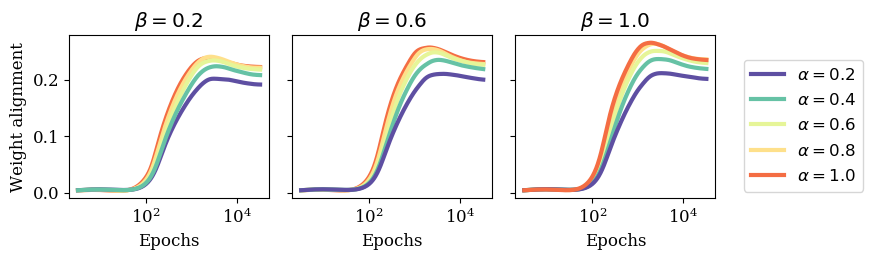

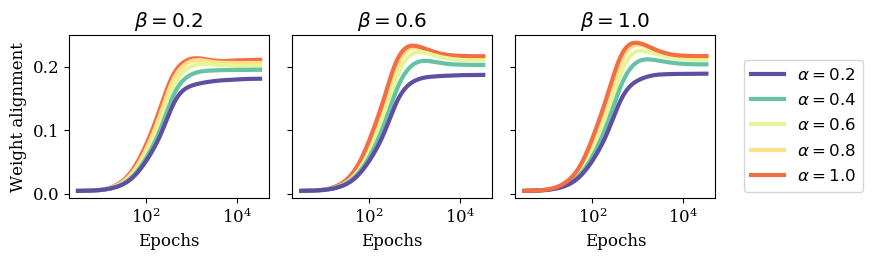

In [254]:
key1 = 'beta'
key2 = 'alpha'
new_params = copy.deepcopy(params)
new_params[key1]=params[key1][::2]

for dataset in ['RANDOM']:
    for activation in ['tanh', 'relu']:

        constraints = {'dataset' : dataset,
                      'activation' : activation}
        
        selected_runs, _ = select_runs(runs, new_params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=True)

        fig, axarr = plt.subplots(1, len(new_params[key1]), figsize=(3*len(new_params[key1]),3), sharey=True)
        n_steps = len(runs[0]['test_loss'])
        for group in sorted(grouped_runs, key=lambda x:getattr(x[0]['args'],key1)):
            args = group[0]['args']
            if getattr(args,key1) not in new_params[key1]: continue
            i = find(new_params[key1], getattr(args, key1))
            j = find(new_params[key2], getattr(args, key2))
            wa = np.mean([run['weight_alignments']['total'] for run in group], axis=0)
            ga = np.mean([run['grad_alignments']['total'] for run in group], axis=0)
            tr = np.mean([run['train_loss'] for run in group], axis=0)
            te = np.mean([run['test_loss'] for run in group], axis=0)
            t = np.array(range(1,len(wa)+1))*args.log_every*args.batch_size/args.datasize
            label=getattr(args, key2)
            color=cmap(j/len(new_params[key2]))
            axarr[i].semilogx(t, wa, color=color, label=label)
        handles, labels = axarr[-1].get_legend_handles_labels()
        handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(float,labels))[k])] )
        labels = [r'$\alpha = {}$'.format(label) for label in labels]
        axarr[-1].legend(handles, labels, bbox_to_anchor=(1.1,.9))

        for i, ax in enumerate(axarr): 
            ax.set_xlabel('Epochs')
            ax.set_title(r'$\beta = {}$'.format(new_params[key1][i]))
            #ax.set_ylim(bottom=0, top=1)
        axarr[0].set_ylabel('Weight alignment')

        #plt.suptitle('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(savedir+'alphabeta_dynamics_{}.pdf'.format(args.activation), bbox_inches='tight')
        plt.show()

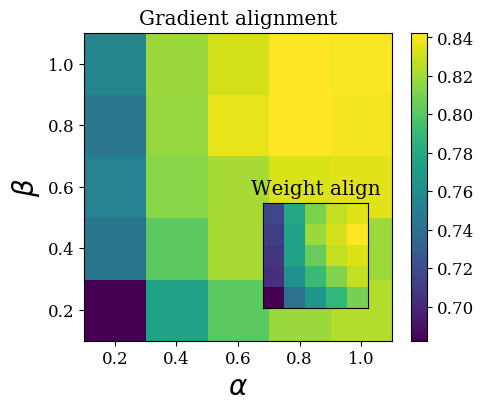

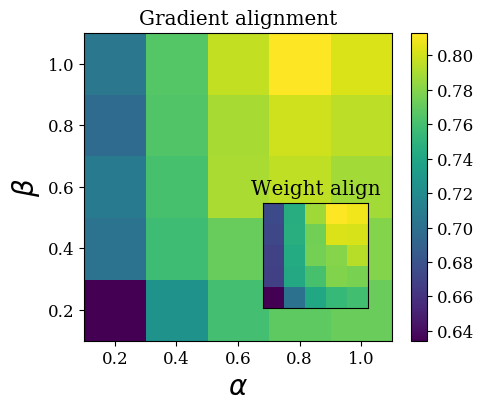

In [194]:
key1 = 'beta'
key2 = 'alpha'

for dataset in ['RANDOM']:
    for activation in ['relu', 'tanh']:

        constraints = {'dataset' : dataset,
                      'activation' : activation}
        
        selected_runs, _ = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=True)

        fig, ax = plt.subplots(1, figsize=(5,4))      
        axins = inset_axes(ax, width='40%', height='40%', loc=4, bbox_to_anchor=(0.1, 0.05, .85, 1), bbox_transform=ax.transAxes)
        grid_ga = np.zeros((len(params[key1]),len(params[key2])))
        grid_wa = np.zeros((len(params[key1]),len(params[key2])))
        grid_tl = np.zeros((len(params[key1]),len(params[key2])))

        for group in grouped_runs:
            args = group[0]['args']
            i,j = find(params[key1], getattr(args, key1)), find(params[key2], getattr(args, key2))
            grid_tl[i,j] = np.mean([run['train_loss'                ][-1] for run in group])
            grid_ga[i,j] = np.mean([run['grad_alignments']  ['total'][-1] for run in group])
            grid_wa[i,j] = np.mean([run['weight_alignments']['total'][-1] for run in group])
        im1 = ax.imshow( grid_ga, origin='lower', )
        axins.   imshow( grid_wa, origin='lower', )
        plt.colorbar(im1, ax=ax)
        #im2 = axarr[1].contourf(np.array(params[key1]), np.array(params[key2]), grid2)
        #plt.colorbar(im2, ax=axarr[1])
        
        ax.set_title('Gradient alignment')
        ax.set_xlabel(r'$\alpha$',fontsize=20)
        ax.set_ylabel(r'$\beta$' ,fontsize=20)
        ax.set_aspect('equal')
        ax.set_xticklabels(['']+params[key1])
        ax.set_yticklabels(['']+params[key2])        
        
        axins.set_title('Weight align')
        axins.set_xticks([])
        axins.set_yticks([])
        axins.set_aspect('equal')

        plt.savefig(savedir+'alphabeta_{}.pdf'.format(args.activation), bbox_inches='tight')
        plt.show()

# Varying width

In [ ]:
path = 'r.1601590379/' # path to folder generated by submit_width.py
runs, params = load_runs(path)

## Statics

In [ ]:
save = True
plot_key = 'hidden_size'
plot_label = 'Width'
log = True
x_var = params[plot_key]

for dataset in ['MNIST','CIFAR10']:
        
    for activation in ['relu', 'tanh']:

        constraints = {'dataset' : dataset,
                       'activation' : activation,
                       'num_classes' : 10}
        selected_runs, params = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs, finished_only=False)

        args=grouped_runs[0][0]['args']
        train_loader, train_loader_log, test_loader, input_size, output_size, input_channels = get_data(args.dataset, args.dataset_path, args.batch_size, test_batch_size=10000, num_classes=args.num_classes, datasize=None)

        best_test_acc   = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        final_test_acc  = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        final_ens_acc   = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        final_train_acc = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        angle           = {'BP':np.zeros((len(x_var),2)), 'DFA':np.zeros((len(x_var),2))}
        grad_overlap = {}
        weight_overlap = {}
        layerwise_angle = {}
        for l in range(runs[0]['args'].n_layers):
            grad_overlap[l] = np.zeros((len(x_var),2))
            weight_overlap[l] = np.zeros((len(x_var),2))
            layerwise_angle[l] = np.zeros((len(x_var),2))

        for igroup, group in enumerate(grouped_runs):
            args = group[0]['args']
            idx = find(params[plot_key],getattr(args, plot_key))
            print('width {}: {} seeds, {} finished'.format(x_var[idx], len(group), len([run for run in group if run['finished']])))
            
            outs = []
            ens_acc = 0#calc_ens_acc(group, test_loader)
            
            best_test_accs=[np.max(run['test_accs']) for run in group]
            final_test_accs =  [   run['test_accs'][-1]    for run in group]
            final_train_accs =   [run['train_accs'][-1]    for run in group]
            best_test_acc[args.training_method][idx]  = [np.mean(best_test_accs),   np.std(best_test_accs)  ]
            final_test_acc[args.training_method][idx] = [np.mean(final_test_accs),  np.std(final_test_accs) ]
            final_train_acc[args.training_method][idx]= [np.mean(final_train_accs), np.std(final_train_accs)]
            final_ens_acc[args.training_method][idx]= ens_acc

            angles = calc_final_angles(group)
            #if len(angles['total'])==0:
                #print(args.name)
            angle[args.training_method][idx] = [np.mean(angles['total']), np.std(angles['total'])]

            if args.training_method=='DFA':
                for l in range(args.n_layers-1):
                    grad_overlaps =   [run['grad_alignments'][l][-1]  for run in group]
                    weight_overlaps = [run['weight_alignments'][l][-1]  for run in group]
                    grad_overlap[l][idx]   = [np.nanmean(grad_overlaps),   np.std(grad_overlaps)  ]
                    weight_overlap[l][idx] = [np.nanmean(weight_overlaps), np.std(weight_overlaps)]
                for l in range(args.n_layers):
                    layerwise_angle[l][idx] = [np.nanmean(angles[l]), np.std(angles[l])]
                    
        fig, axarr = plt.subplots(1,3,figsize=(12,4))

        for i, (k, v) in enumerate(final_train_acc.items()) :
            axarr[0].errorbar(x_var, 100-v[:,0], yerr=v[:,1], color='k' if i else 'grey', label=k)
        axarr[0].legend()
        axarr[0].set_xlabel(plot_key)
        axarr[0].set_ylabel('Train error')
        axarr[1].set_ylabel('Cosine similarity of weights')
        for l in range(args.n_layers):
            axarr[1].errorbar(x_var, layerwise_angle[l][:,0], yerr=layerwise_angle[l][:,1], label='layer %d'%(l+1))
        axarr[1].errorbar(x_var, angle['BP'][:,0], yerr=angle['BP'][:,1], label='BP', color='grey')
        
        for l in range(args.n_layers-1):
            axarr[2].errorbar(x_var, grad_overlap[l][:,0], yerr=grad_overlap[l][:,1], label='layer %d'%(l+1))
        axarr[2].set_ylabel('Gradient alignment')
        
        for i, ax in enumerate(axarr):
            ax.set_xlabel(plot_label)
            ax.legend()
            ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
        if log:
            for ax in axarr: ax.set_xscale('log')

        #plt.suptitle('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save: plt.savefig(savedir+'Results_statics_{}_{}.pdf'.format(args.dataset, args.activation), bbox_inches='tight')
        plt.show()

## Dynamics

In [ ]:
label_key = 'hidden_size'
x = params[label_key]

for dataset in ['MNIST', 'CIFAR10']:
    for activation in ['relu','tanh']:

        constraints = {'dataset' : dataset,
                   'activation' : activation,
                      'num_classes':10}
        
        selected_runs, _ = select_runs(runs, params, constraints)
        grouped_runs = group_runs(selected_runs)

        fig, axarr = plt.subplots(1,4, figsize=(14,4))
        n_steps = len(runs[0]['test_loss'])
        for group in grouped_runs:
            args = group[0]['args']
            i = find(x,getattr(args, label_key))
            try:
                train_acc = np.mean([run['train_accs']           for run in group], axis=0)
                test_acc  = np.mean([run[ 'test_accs']           for run in group], axis=0)
                a1        = np.mean([run['weight_alignments'][2] for run in group], axis=0)
                a2        = np.mean([run['grad_alignments'][2]   for run in group], axis=0)            
            except:
                print('Failed for {} {}'.format(label_key, x[i]))
                continue

            t = np.array(range(1,len(train_acc)+1))*args.log_every
            label=getattr(args, label_key)
            color=cmap(i/len(x))
            if args.training_method == 'BP':
                axarr[0].semilogx(t, 100-train_acc, color=color, label=label)
            else :   
                axarr[1].semilogx(t, 100-train_acc,color=color, label=label)
                axarr[2].semilogx(t, a1,           color=color, label=label)
                axarr[3].semilogx(t, a2,           color=color, label=label)
        #axarr[2].set_ylim(bottom=.5)
        #axarr[3].set_ylim(bottom=.5)
        handles, labels = plt.gca().get_legend_handles_labels()
        handles, labels = zip(*[ (handles[i], labels[i]) for i in sorted(range(len(handles)), key=lambda k: list(map(int,labels))[k])] )
        labels = ['Width = '+label for label in labels]
        plt.legend(handles, labels, bbox_to_anchor=(1.1,1.1))
        for i, ax in enumerate(axarr): 
            ax.set_xlabel('SGD step')
            ax.text(-0.1, 1.1, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
        axarr[0].set_ylabel('BP train error')
        axarr[1].set_ylabel('DFA train error')
        axarr[2].set_ylabel('WA last layer')
        axarr[3].set_ylabel('GA last layer')
    
        print('{} {}'.format(args.dataset, args.activation))
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(savedir+'Results_dynamics_{}_{}.pdf'.format(args.dataset, args.activation), bbox_inches='tight')
        plt.show()